# Distraction classes confusion matrices

The aim here is to plot a separate confusion matrix for each of the 'distraction' classes e.g. wind, rain etc

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import cPickle as pickle
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.ndimage.interpolation import zoom
import collections
from sklearn.metrics import confusion_matrix

def force_make_dir(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
    return dirpath

/home/michael/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/home/michael/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [7]:
#run_type = 'ensemble_train_2'
run_type = 'warblr_challenge_baseline'
classname = 'biotic'

base_dir = '/media/michael/Engage/data/audio/alison_data/golden_set/'
labels_dir = base_dir + 'labels/Golden/'

results_dir = base_dir + 'predictions/%s/%s/per_file_predictions/' % (run_type, classname)
annotation_pkl_dir = base_dir + 'extracted/annotations/'

# where to save
savedir = force_make_dir(results_dir + '../distractors_analysis/')

In [8]:
def load_annotation_class(label_filename, classes_to_use):
    '''
    Create a label vector for a specific class or set of classes, 
    for a single file
    '''
    pd_annots = pd.read_csv(label_filename)

    # create label vector...
    sample_rate = 22050
    label_vector = np.zeros((sample_rate * 60))  # sample rate x 60 seconds

    # loop over each annotation...
    for _, annot in pd_annots.iterrows():

        # fill in the label vector
        start_point = int(float(annot['LabelStartTime_Seconds']) * sample_rate)
        end_point =  int(float(annot['LabelEndTime_Seconds']) * sample_rate)

        if annot['Label'].lower() in classes_to_use:
            label_vector[start_point:end_point] = 1

    return label_vector

In [9]:
# Loading the data label converters
converters = pd.read_csv(base_dir + 'choosingLabelsForAudiotagger.csv')
sound_label_groups = collections.defaultdict(list)
for idx, row in converters.iterrows():
    sound_label_groups[row['Convert to']].append(row['Label'])
sound_label_groups['Air traffic'].append('air traffic')
sound_label_groups['Road traffic'].append('road traffic')
sound_label_groups['Road traffic'].append('mix traffic')
 

In [10]:
# setting up which distractors we want to analyse
distractors = ['Air traffic', 'Braking vehicle (road or rail)', 'Electrical disturbance', 
               'Human Voice', 'Mechanical', 'Rail Traffic', 'Rain', 'Road traffic', 
               'Siren', 'Vehicle horn (road or rail)', 'Wind']

In [11]:
def correct_wrong(totals):
    return totals['tp'] + totals['tn'], totals['fp'] + totals['fn']


differences = {}
all_with_without_scores = {}

print run_type
print "Type, Correct, Wrong"

# load in the annotations
for name in distractors:    
    
    distractor_classes = sound_label_groups[name]

    tmp = dict.fromkeys(['tm', 'tp', 'tn', 'fp', 'fn'], 0)
    totals = [tmp.copy(), tmp.copy()]
    all_y_true = []
    all_y_pred = []

    for fname in os.listdir(labels_dir):

        # load the annottion
        distractor_labels = load_annotation_class(labels_dir + fname, distractor_classes)

        pred_file = results_dir + fname.replace('-sceneRect.csv', '.pkl')
        y_true, y_pred_proba = pickle.load(open(pred_file))
        

        # resizing predictions
        if 'golden' not in run_type:
            y_true, _ = pickle.load(open(
                pred_file.replace(run_type, 'mel32_large_test_golden_fullsplit')))
            
            factor = y_true.shape[0] / float(y_pred_proba.shape[0])
            y_pred_proba = zoom(y_pred_proba, (factor, 1.0), order=1)
            
        y_pred_class = y_pred_proba[:, 1] > 0.5

        # resizing distractors
        factor = y_true.shape[0] / float(distractor_labels.shape[0])
        distractor_labels = zoom(distractor_labels, factor, order=1)

        # finaly adding to the lists
        all_y_true.append(y_true[distractor_labels > 0.5])
        all_y_pred.append(y_pred_class[distractor_labels > 0.5])
        
        slice_size = 60.0 / y_true.shape[0]

        # loop over moments with both dont (0) and do (1) have the distractor sound
        for distractor_class in [0, 1]:
            tmp = totals[distractor_class]
            idxs = distractor_labels > 0.5 if distractor_class else distractor_labels < 0.5
            _y_true = y_true[idxs]
            _y_pred = y_pred_class[idxs]
            
            tmp['tm'] += _y_true.shape[0]
            tmp['tp'] += np.logical_and(_y_true == _y_pred, _y_true == 1).sum()
            tmp['tn'] += np.logical_and(_y_true == _y_pred, _y_true == 0).sum()
            tmp['fp'] += np.logical_and(_y_true != _y_pred, _y_true == 0).sum()
            tmp['fn'] += np.logical_and(_y_true != _y_pred, _y_true == 1).sum()

    ############################################################
    # PLOTTING CONFUSION MATRIX
#     print "\nPlotting conf matrix for %s:" % name
#     print distractor_classes
    all_y_true = np.round(np.hstack(all_y_true))
    all_y_pred = np.hstack(all_y_pred).astype(float)
    if len(all_y_true) == 0:
#         print "Skipping - there are no items here"
        continue

    cm = (confusion_matrix(all_y_true, all_y_pred) * slice_size).astype(int)[::-1]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes((0.18,0.1,0.8,0.8))
    ax = sns.heatmap(cm, annot=True, fmt="d", ax=ax)
    #plt.savefig(savedir + 'confusion_matrix1.pdf')
    ax.grid('off')
    ax.set_aspect(1.0)
    plt.xticks([0.5, 1.5], ['None', classname.capitalize()])
    plt.yticks([0.5, 1.5], ['None', classname.capitalize()])
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.ylabel('Actual', fontsize=20)
    plt.xlabel('Predicted', fontsize=20)

    plt.savefig(savedir + '%s.pdf' % name)
    plt.savefig(savedir + '%s.png' % name, dpi=800)
    plt.close()
    
    ############################################################
    # Working out change in performance with/without distractor
    scores = [np.nan, np.nan]
    for distractor_present, total in enumerate(totals):
        if distractor_present:
            
            if len(differences) == 0:
#                 print "For all data: ",
#                 print "Correct: %d, wrong: %d" % correct_wrong({key: totals[0][key] + totals[1][key] for key in total})
                print "All_data, %d, %d" % correct_wrong({key: totals[0][key] + totals[1][key] for key in total})

            print "%s," % name,
            print "%d, %d" % correct_wrong(total)
            
            
        if sum(total[key] for key in ['tp', 'fn']):
            A = float(total['tp']) / sum(total[key] for key in ['tp', 'fn'])
        else:
            A = np.nan

        if sum(total[key] for key in ['fp', 'tn']):
            B = float(total['tn']) / sum(total[key] for key in ['fp', 'tn'])
        else:
            B = np.nan

        # this is a balanced score already
        scores[distractor_present] = np.nansum((A, B)) / sum(~np.isnan((A, B)))

    differences[name] = np.diff(scores)
    all_with_without_scores[name] = scores

warblr_challenge_baseline
Type, Correct, Wrong
All_data, 41118, 10574
Air traffic, 8765, 3047
Mechanical, 183, 47
Rain, 2491, 701
Road traffic, 30851, 7255
Siren, 1312, 264
Wind, 838, 316


In [12]:
print all_y_pred.dtype
print all_y_true.dtype
print all_y_pred.shape
print all_y_true.shape
print len(np.unique(all_y_pred))
print len(np.unique(all_y_true))
print np.unique(all_y_true)

float64
int32
(1154,)
(1154,)
2
2
[0 1]


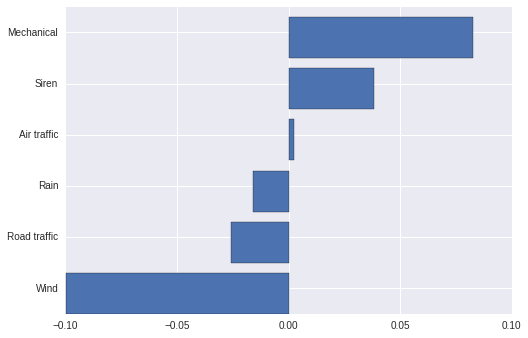

In [15]:
# Plotting the change in balanced accuracy with/without the sound type
items = differences.items()
items = sorted(items, key = lambda x:x[1])
Y = np.arange(len(items))

ax = plt.barh(Y, [xx[1] for xx in items])
plt.yticks(Y + 0.5, [xx[0] for xx in items]);

In [14]:
for key, val in all_with_without_scores.items():
    diff = 100 * (val[1] - val[0]) / (val[0])
    print "{: <16}{:05.3f}    {:05.3f}    {:+04.2f}%".format(key, val[0], val[1], diff)

Siren           0.712    0.750    +5.41%
Rain            0.714    0.698    -2.25%
Road traffic    0.726    0.700    -3.55%
Mechanical      0.713    0.796    +11.57%
Air traffic     0.708    0.711    +0.37%
Wind            0.715    0.616    -13.92%


In [24]:
for key, val in all_with_without_scores.items():
    diff = differences[key][0] * 100
    print "{: <16}  {:+05.2f}".format(key, diff)

Siren             -5.24
Rain              -21.54
Road traffic      -9.34
Mechanical        -22.26
Air traffic       -27.78
Wind              +6.39
